# Forecasting Sales
We are given a series of sales data and the corresponding sales budgets we wish to achieve at the same time. We would like to tell the future and predict that whether we will hit our expected volume of sales / sales budget in the upcoming months.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = r'Monthly Sales for Laptops - Test.xlsx'
df = pd.read_excel(file)
df.head()

,Month,Sales,Budget
0,2014-01-01,14840.0,13740.0
1,2014-02-01,14820.0,16466.0
2,2014-03-01,17920.0,18474.0
3,2014-04-01,19020.0,17449.0
4,2014-05-01,20600.0,22150.0


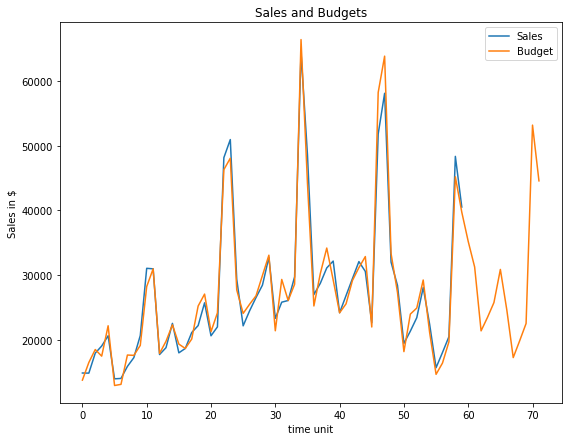

In [3]:
## larger figures
plt.rcParams['figure.figsize'] = [9, 7]

sales_df = df[['Sales']];
budget_df = df[['Budget']];

plt.plot(sales_df, label='Sales');
plt.plot(budget_df, label='Budget');
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('Sales and Budgets')
plt.legend();

In [4]:
sales_df = sales_df.dropna().to_numpy()
budget_df = budget_df.to_numpy()

In [5]:
iStartEnd = int(np.floor(0.8 * sales_df.shape[0]))
data_training = sales_df[np.arange(0, iStartEnd)]
data_testing = sales_df[np.arange(iStartEnd, sales_df.shape[0])]
data_training.shape

(48, 1)

In [6]:
data_testing.shape

(12, 1)

In [7]:
import tensorflow as tf

In [8]:
data_training = tf.keras.utils.normalize(data_training, axis=0, order=1)
data_testing = tf.keras.utils.normalize(data_testing, axis=0, order=1)

In [9]:
global SET_SIZE;

def generate_x_y(data, size, length):
    x_data = np.zeros((length - size, size), dtype=float)
    y_data = np.zeros((length - size, 1), dtype=float)
    for i in range(size-1, length):
        segment = data[np.arange(i - size, i)]
        x_data[i - size] = np.reshape(segment, (-1, size))
        y_data[i - size] = data[i]
    return x_data, y_data

In [10]:
SET_SIZE = 10
x_training, y_training = generate_x_y(data_training, SET_SIZE, data_training.shape[0])
x_testing, y_testing = generate_x_y(data_testing, SET_SIZE, data_testing.shape[0])

In [11]:
print("For example, the prediction of ", x_training[0], ', is ', y_training[0])

For example, the prediction of  [0.01129926 0.01128403 0.01364439 0.01448194 0.01568496 0.010614
 0.01065968 0.0120759  0.01311141 0.01571542] , is  [0.02363404]


In [12]:
from tensorflow.keras import datasets, layers, models

my_model = models.Sequential([
    layers.LSTM(SET_SIZE, return_sequences=True, input_shape=(SET_SIZE, 1)),
    layers.LSTM(SET_SIZE, return_sequences=False),
    layers.Dense(SET_SIZE * 2),
    layers.Dense(1)
])
    
my_model.compile(optimizer='adam', loss='mean_squared_error')

my_model.fit(np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1)),
             y_training, epochs=20, batch_size=512);

Train on 38 samples
Epoch 1/20
38/38 [==============================] - 4s 117ms/sample - loss: 5.1679e-04
Epoch 2/20
38/38 [==============================] - 0s 426us/sample - loss: 2.3508e-04
Epoch 3/20
38/38 [==============================] - 0s 778us/sample - loss: 9.3890e-05
Epoch 4/20
38/38 [==============================] - 0s 440us/sample - loss: 7.9174e-05
Epoch 5/20
38/38 [==============================] - 0s 541us/sample - loss: 1.3739e-04
Epoch 6/20
38/38 [==============================] - 0s 685us/sample - loss: 1.8916e-04
Epoch 7/20
38/38 [==============================] - 0s 411us/sample - loss: 1.9629e-04
Epoch 8/20
38/38 [==============================] - 0s 623us/sample - loss: 1.6729e-04
Epoch 9/20
38/38 [==============================] - 0s 637us/sample - loss: 1.2542e-04
Epoch 10/20
38/38 [==============================] - 0s 501us/sample - loss: 9.0589e-05
Epoch 11/20
38/38 [==============================] - 0s 637us/sample - loss: 7.3527e-05
Epoch 12/20
38/38 [==

In [13]:
my_model.evaluate(np.reshape(x_testing, (x_testing.shape[0], x_testing.shape[1], 1)), 
                  y_testing, batch_size=128);

2/2 [==============================] - 1s 519ms/sample - loss: 0.0123


In [14]:
new_sales_df = sales_df
new_sales_df = np.append(new_sales_df, np.zeros(budget_df.shape[0] - sales_df.shape[0]))

In [15]:
for i in range(sales_df.shape[0], new_sales_df.shape[0]):
    data_to_predict = new_sales_df[i - SET_SIZE:i]
    new_sales_df[i] = my_model.predict(np.reshape(data_to_predict, 
                                                  (1, data_to_predict.shape[0], 1)))[0, 0]

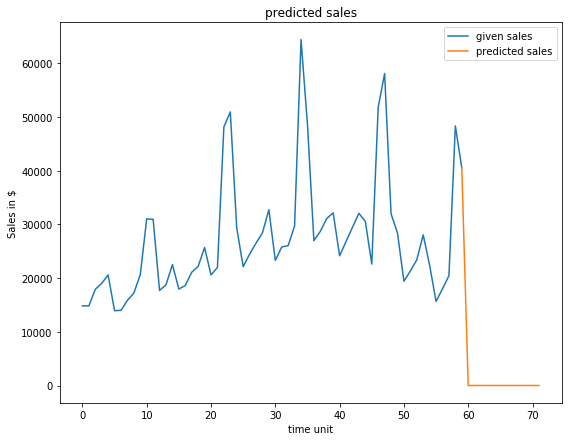

In [16]:
plt.plot(np.arange(sales_df.shape[0]), sales_df, label='given sales');
plt.plot(np.arange(sales_df.shape[0] - 1, new_sales_df.shape[0]), 
         new_sales_df[sales_df.shape[0] - 1: new_sales_df.shape[0]], label='predicted sales')
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('predicted sales');
plt.legend();

Our prediction is **fair and reasonable**, as we do see decreasing sales with the given data. The general trend looks much like a concaved-down quadratic curve. And the parts we are predicting mostly lies on the decreasing part of the curve.

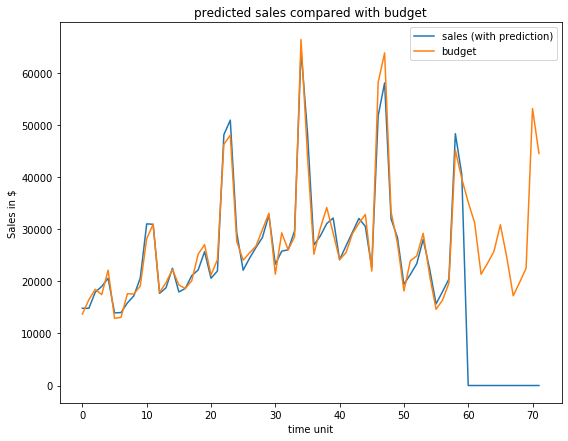

In [17]:
plt.plot(np.arange(new_sales_df.shape[0]), new_sales_df, label='sales (with prediction)');
plt.plot(np.arange(budget_df.shape[0]), budget_df, label='budget');
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('predicted sales compared with budget');
plt.legend();

So, in conclusion, we **will not achieve our sales budget**, and is by a large amount.